In [1]:
!nvidia-smi

Thu Feb 22 19:31:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   36C    P5              23W / 215W |    774MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/CREMA-D/'

In [8]:
sr = 16000

x_train = np.load(f'{data_dir}crema_d.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}crema_d.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)

In [9]:
labels = ['ANG', 'NEU', 'SAD']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in y_train]
x_train = x_train[filtered_idx]
y_train = [label_to_index(idx) for idx in y_train[filtered_idx]]
print(x_train.shape)

filtered_idx = [label_filter(idx) for idx in y_test]
x_test = x_test[filtered_idx]
y_test = [label_to_index(idx) for idx in y_test[filtered_idx]]
print(x_test.shape)

(2508,)
(759,)


In [10]:
l = [len(i) for i in x_train]
print(min(l))
print(max(l))
sum(l) / len(l)

21355
80080


40594.362041467306

In [11]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [12]:
sample_rate=16000

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=3, sample_rate=16000):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 32

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
from IConNet.nn.model import M12

In [15]:
from omegaconf import OmegaConf as ocf

In [16]:
import traceback

In [17]:
model_config_path = 'config/model/m12_debug.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M12_debug', 'description': 'FirConv sequential for iemocap', 'fe': {'n_block': 2, 'n_channel': [64, 32], 'kernel_size': [63, 31], 'stride': [4, 4], 'window_k': [5, 9], 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 48, 'pooling': 'max', 'use_context': False, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256], 'norm_type': 'LayerNorm'}}

In [18]:
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
model

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [19]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [20]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [21]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▎                                                                                                                                                                             | 0.019801980198019802/10 [00:00<05:11, 31.19s/it]

Train Epoch: 1 [0/2508 (0%)]	Loss: 1.145589
Mem before-during-after: 528384 1929975296 21014016


  4%|███████▎                                                                                                                                                                       | 0.41584158415841604/10 [00:10<03:52, 24.23s/it]

Train Epoch: 1 [1280/2508 (51%)]	Loss: 0.887716
Mem before-during-after: 21014016 1940225024 21014016


 10%|█████████████████▌                                                                                                                                                              | 1.0000000000000007/10 [00:23<02:38, 17.61s/it]


Test Epoch: 1	Accuracy: 557/736 (73%)



 10%|█████████████████▉                                                                                                                                                              | 1.0198019801980205/10 [00:23<02:54, 19.43s/it]

Train Epoch: 2 [0/2508 (0%)]	Loss: 0.689239
Mem before-during-after: 21009920 1941396480 21014016


 14%|████████████████████████▉                                                                                                                                                       | 1.4158415841584169/10 [00:33<03:30, 24.52s/it]

Train Epoch: 2 [1280/2508 (51%)]	Loss: 0.456255
Mem before-during-after: 21014016 1939457024 21014016


 20%|███████████████████████████████████▏                                                                                                                                            | 2.0000000000000013/10 [00:46<02:35, 19.42s/it]


Test Epoch: 2	Accuracy: 575/736 (76%)



 20%|███████████████████████████████████▎                                                                                                                                            | 2.0099009900990112/10 [00:46<02:47, 21.01s/it]

Train Epoch: 3 [0/2508 (0%)]	Loss: 0.645834
Mem before-during-after: 21009920 1941396480 21014016


 24%|██████████████████████████████████████████▎                                                                                                                                     | 2.4059405940594076/10 [00:56<03:15, 25.76s/it]

Train Epoch: 3 [1280/2508 (51%)]	Loss: 0.538253
Mem before-during-after: 21014016 1940235264 21014016


 30%|█████████████████████████████████████████████████████                                                                                                                            | 3.000000000000002/10 [01:09<02:03, 17.64s/it]


Test Epoch: 3	Accuracy: 564/736 (74%)



 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 3.019801980198022/10 [01:10<02:15, 19.35s/it]

Train Epoch: 4 [0/2508 (0%)]	Loss: 0.592789
Mem before-during-after: 21009920 1941396480 21014016


 34%|████████████████████████████████████████████████████████████                                                                                                                    | 3.4158415841584184/10 [01:19<02:40, 24.40s/it]

Train Epoch: 4 [1280/2508 (51%)]	Loss: 0.642460
Mem before-during-after: 21014016 1939457024 21014016


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 4.000000000000003/10 [01:32<02:01, 20.30s/it]


Test Epoch: 4	Accuracy: 534/736 (70%)



 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                         | 4.0198019801980225/10 [01:33<02:02, 20.43s/it]

Train Epoch: 5 [0/2508 (0%)]	Loss: 0.410104
Mem before-during-after: 21009920 1941396480 21014016


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 4.415841584158419/10 [01:43<02:16, 24.47s/it]

Train Epoch: 5 [1280/2508 (51%)]	Loss: 0.590933
Mem before-during-after: 21014016 1940145152 21014016


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5.0000000000000036/10 [01:56<01:33, 18.77s/it]


Test Epoch: 5	Accuracy: 561/736 (74%)



 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 5.019801980198023/10 [01:56<01:37, 19.58s/it]

Train Epoch: 6 [0/2508 (0%)]	Loss: 0.634561
Mem before-during-after: 21009920 1941396480 21014016


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 5.40594059405941/10 [02:06<01:56, 25.36s/it]

Train Epoch: 6 [1280/2508 (51%)]	Loss: 0.399815
Mem before-during-after: 21014016 1940235264 21014016


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6.000000000000004/10 [02:19<01:10, 17.68s/it]


Test Epoch: 6	Accuracy: 567/736 (75%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 6.019801980198024/10 [02:19<01:16, 19.30s/it]

Train Epoch: 7 [0/2508 (0%)]	Loss: 0.556609
Mem before-during-after: 21009920 1941396480 21014016


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 6.415841584158421/10 [02:29<01:27, 24.46s/it]

Train Epoch: 7 [1280/2508 (51%)]	Loss: 0.581864
Mem before-during-after: 21014016 1940235264 21014016


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7.000000000000005/10 [02:42<00:52, 17.57s/it]


Test Epoch: 7	Accuracy: 572/736 (75%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 7.019801980198025/10 [02:42<00:56, 18.98s/it]

Train Epoch: 8 [0/2508 (0%)]	Loss: 0.406566
Mem before-during-after: 21009920 1941396480 21014016


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7.4158415841584215/10 [02:52<01:01, 23.77s/it]

Train Epoch: 8 [1280/2508 (51%)]	Loss: 0.645310
Mem before-during-after: 21014016 1939457024 21014016


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8.000000000000005/10 [03:04<00:34, 17.49s/it]


Test Epoch: 8	Accuracy: 566/736 (75%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 8.019801980198023/10 [03:05<00:38, 19.38s/it]

Train Epoch: 9 [0/2508 (0%)]	Loss: 0.619100
Mem before-during-after: 21009920 1936208384 21014016


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8.415841584158384/10 [03:15<00:42, 26.94s/it]

Train Epoch: 9 [1280/2508 (51%)]	Loss: 0.895559
Mem before-during-after: 21014016 1940145152 21014016


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8.999999999999917/10 [03:28<00:17, 17.96s/it]


Test Epoch: 9	Accuracy: 571/736 (75%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 9.019801980197935/10 [03:28<00:18, 19.33s/it]

Train Epoch: 10 [0/2508 (0%)]	Loss: 0.684581
Mem before-during-after: 21009920 1941396480 21014016


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9.415841584158295/10 [03:37<00:13, 23.55s/it]

Train Epoch: 10 [1280/2508 (51%)]	Loss: 0.707989
Mem before-during-after: 21014016 1940235264 21014016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999828/10 [03:50<00:00, 23.07s/it]


Test Epoch: 10	Accuracy: 572/736 (75%)



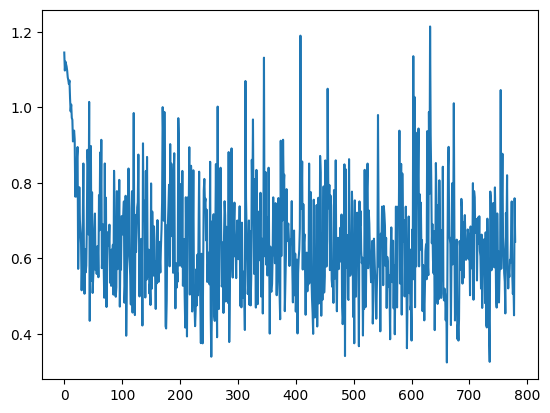

In [22]:
plt.plot(train_losses)

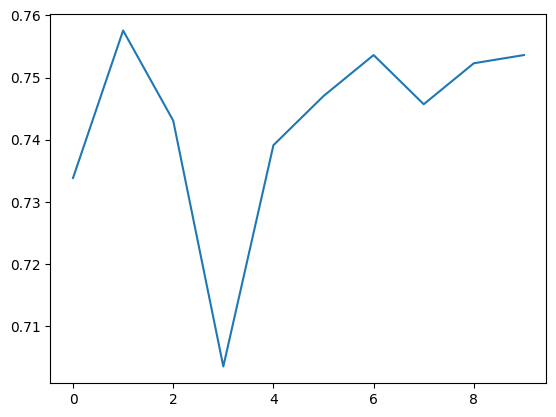

In [23]:
plt.plot(test_accuracy)

In [24]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [25]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 572/736 (0.7772)
{'acc_detail': tensor([0.8479, 0.6335, 0.8294], device='cuda:0'),
 'acc_unweighted': tensor(0.7703, device='cuda:0'),
 'acc_weighted': tensor(0.7772, device='cuda:0'),
 'f1s': tensor(0.7706, device='cuda:0'),
 'f1s_detail': tensor([0.8780, 0.6437, 0.7902], device='cuda:0'),
 'precision_detail': tensor([0.9102, 0.6542, 0.7545], device='cuda:0'),
 'recall_detail': tensor([0.8479, 0.6335, 0.8294], device='cuda:0'),
 'rocauc': tensor([0.9728, 0.8702, 0.9273], device='cuda:0'),
 'uar': tensor(0.7703, device='cuda:0'),
 'wap': tensor(0.7800, device='cuda:0')}


tensor([[223,  37,   3],
        [ 16, 140,  65],
        [  6,  37, 209]], device='cuda:0')

In [27]:
model_path = '../models_cremad3/cremad_label3_m12new_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [28]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad3/cremad_label3_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.019801980198019802/50 [00:00<18:35, 22.31s/it]

Train Epoch: 11 [0/2508 (0%)]	Loss: 0.967925
Mem before-during-after: 20003328 1940389888 21060096


  1%|█▍                                                                                                                                                                             | 0.41584158415841604/50 [00:11<21:47, 26.37s/it]

Train Epoch: 11 [1280/2508 (51%)]	Loss: 0.742339
Mem before-during-after: 21060096 1940281344 21060096


  2%|███▌                                                                                                                                                                            | 1.0000000000000007/50 [00:25<16:56, 20.75s/it]


Test Epoch: 11	Accuracy: 579/736 (76%)

saved model: ../models_cremad3/cremad_label3_m12new_best_11epoch.pt


  2%|███▌                                                                                                                                                                            | 1.0198019801980205/50 [00:25<17:43, 21.72s/it]

Train Epoch: 12 [0/2508 (0%)]	Loss: 0.704264
Mem before-during-after: 21056000 1941442560 21060096


  3%|████▉                                                                                                                                                                           | 1.4158415841584169/50 [00:36<22:04, 27.27s/it]

Train Epoch: 12 [1280/2508 (51%)]	Loss: 0.566800
Mem before-during-after: 21060096 1939503104 21060096


  4%|███████                                                                                                                                                                         | 2.0000000000000013/50 [00:50<15:40, 19.60s/it]


Test Epoch: 12	Accuracy: 581/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_12epoch.pt


  4%|███████▏                                                                                                                                                                         | 2.019801980198021/50 [00:50<16:43, 20.92s/it]

Train Epoch: 13 [0/2508 (0%)]	Loss: 0.783985
Mem before-during-after: 21056000 1941442560 21060096


  5%|████████▍                                                                                                                                                                       | 2.4059405940594076/50 [01:00<21:49, 27.51s/it]

Train Epoch: 13 [1280/2508 (51%)]	Loss: 0.492851
Mem before-during-after: 21060096 1940281344 21060096


  6%|██████████▌                                                                                                                                                                      | 3.000000000000002/50 [01:15<16:14, 20.73s/it]


Test Epoch: 13	Accuracy: 579/736 (76%)



  6%|██████████▋                                                                                                                                                                      | 3.009900990099012/50 [01:15<17:58, 22.96s/it]

Train Epoch: 14 [0/2508 (0%)]	Loss: 0.438624
Mem before-during-after: 21056000 1941442560 21060096


  7%|███████████▉                                                                                                                                                                    | 3.4059405940594085/50 [01:25<23:05, 29.74s/it]

Train Epoch: 14 [1280/2508 (51%)]	Loss: 0.468595
Mem before-during-after: 21060096 1940281344 21060096


  8%|██████████████▏                                                                                                                                                                  | 4.000000000000003/50 [01:39<14:48, 19.32s/it]


Test Epoch: 14	Accuracy: 581/736 (77%)



  8%|██████████████▏                                                                                                                                                                 | 4.0198019801980225/50 [01:40<15:54, 20.76s/it]

Train Epoch: 15 [0/2508 (0%)]	Loss: 0.738144
Mem before-during-after: 21056000 1941442560 21060096


  9%|███████████████▌                                                                                                                                                                 | 4.405940594059409/50 [01:50<21:20, 28.08s/it]

Train Epoch: 15 [1280/2508 (51%)]	Loss: 0.501296
Mem before-during-after: 21060096 1940281344 21060096


 10%|█████████████████▌                                                                                                                                                              | 5.0000000000000036/50 [02:04<14:34, 19.44s/it]


Test Epoch: 15	Accuracy: 578/736 (76%)



 10%|█████████████████▊                                                                                                                                                               | 5.019801980198023/50 [02:04<15:28, 20.65s/it]

Train Epoch: 16 [0/2508 (0%)]	Loss: 0.555987
Mem before-during-after: 21056000 1941442560 21060096


 11%|███████████████████▏                                                                                                                                                              | 5.40594059405941/50 [02:14<20:27, 27.53s/it]

Train Epoch: 16 [1280/2508 (51%)]	Loss: 0.541986
Mem before-during-after: 21060096 1940281344 21060096


 12%|█████████████████████▏                                                                                                                                                           | 6.000000000000004/50 [02:28<14:52, 20.28s/it]


Test Epoch: 16	Accuracy: 582/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_16epoch.pt


 12%|█████████████████████▎                                                                                                                                                           | 6.019801980198024/50 [02:29<16:09, 22.04s/it]

Train Epoch: 17 [0/2508 (0%)]	Loss: 0.644156
Mem before-during-after: 21056000 1941442560 21060096


 13%|██████████████████████▋                                                                                                                                                          | 6.415841584158421/50 [02:39<18:21, 25.28s/it]

Train Epoch: 17 [1280/2508 (51%)]	Loss: 0.643811
Mem before-during-after: 21060096 1939503104 21060096


 14%|████████████████████████▊                                                                                                                                                        | 7.000000000000005/50 [02:53<13:41, 19.11s/it]


Test Epoch: 17	Accuracy: 579/736 (76%)



 14%|████████████████████████▊                                                                                                                                                        | 7.009900990099015/50 [02:53<15:12, 21.23s/it]

Train Epoch: 18 [0/2508 (0%)]	Loss: 0.607492
Mem before-during-after: 21056000 1941442560 21060096


 15%|██████████████████████████▏                                                                                                                                                      | 7.405940594059412/50 [03:03<19:37, 27.64s/it]

Train Epoch: 18 [1280/2508 (51%)]	Loss: 0.754397
Mem before-during-after: 21060096 1938351616 21060096


 16%|████████████████████████████▎                                                                                                                                                    | 8.000000000000005/50 [03:17<13:55, 19.90s/it]


Test Epoch: 18	Accuracy: 588/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_18epoch.pt


 16%|████████████████████████████▎                                                                                                                                                    | 8.009900990099014/50 [03:18<15:16, 21.83s/it]

Train Epoch: 19 [0/2508 (0%)]	Loss: 0.510151
Mem before-during-after: 21056000 1941442560 21060096


 17%|█████████████████████████████▊                                                                                                                                                   | 8.415841584158384/50 [03:28<17:25, 25.15s/it]

Train Epoch: 19 [1280/2508 (51%)]	Loss: 0.450139
Mem before-during-after: 21060096 1940281344 21060096


 18%|███████████████████████████████▊                                                                                                                                                 | 8.999999999999917/50 [03:42<13:07, 19.21s/it]


Test Epoch: 19	Accuracy: 582/736 (77%)



 18%|███████████████████████████████▉                                                                                                                                                 | 9.019801980197935/50 [03:43<14:14, 20.85s/it]

Train Epoch: 20 [0/2508 (0%)]	Loss: 0.453713
Mem before-during-after: 21056000 1941442560 21060096


 19%|█████████████████████████████████▎                                                                                                                                               | 9.405940594059286/50 [03:53<18:25, 27.22s/it]

Train Epoch: 20 [1280/2508 (51%)]	Loss: 0.515461
Mem before-during-after: 21060096 1940281344 21060096


 20%|███████████████████████████████████▍                                                                                                                                             | 9.999999999999828/50 [04:07<13:34, 20.37s/it]


Test Epoch: 20	Accuracy: 584/736 (77%)



 20%|███████████████████████████████████▏                                                                                                                                            | 10.009900990098837/50 [04:07<14:50, 22.26s/it]

Train Epoch: 21 [0/2508 (0%)]	Loss: 0.352268
Mem before-during-after: 21056000 1941442560 21060096


 21%|████████████████████████████████████▋                                                                                                                                           | 10.405940594059198/50 [04:17<18:38, 28.25s/it]

Train Epoch: 21 [1280/2508 (51%)]	Loss: 0.627884
Mem before-during-after: 21060096 1939503104 21060096


 22%|██████████████████████████████████████▋                                                                                                                                         | 10.999999999999739/50 [04:31<12:53, 19.83s/it]


Test Epoch: 21	Accuracy: 586/736 (77%)



 22%|██████████████████████████████████████▊                                                                                                                                         | 11.009900990098748/50 [04:32<13:59, 21.52s/it]

Train Epoch: 22 [0/2508 (0%)]	Loss: 0.639618
Mem before-during-after: 21056000 1941442560 21060096


 23%|████████████████████████████████████████▏                                                                                                                                       | 11.405940594059109/50 [04:42<17:42, 27.52s/it]

Train Epoch: 22 [1280/2508 (51%)]	Loss: 0.623801
Mem before-during-after: 21060096 1940281344 21060096


 24%|██████████████████████████████████████████▍                                                                                                                                      | 11.99999999999965/50 [04:56<12:14, 19.34s/it]


Test Epoch: 22	Accuracy: 584/736 (77%)



 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.009900990098659/50 [04:57<13:24, 21.17s/it]

Train Epoch: 23 [0/2508 (0%)]	Loss: 0.342155
Mem before-during-after: 21056000 1941442560 21060096


 25%|███████████████████████████████████████████▉                                                                                                                                     | 12.40594059405902/50 [05:07<17:08, 27.37s/it]

Train Epoch: 23 [1280/2508 (51%)]	Loss: 0.518526
Mem before-during-after: 21060096 1940191232 21060096


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 12.999999999999561/50 [05:21<12:18, 19.95s/it]


Test Epoch: 23	Accuracy: 583/736 (77%)



 26%|██████████████████████████████████████████████                                                                                                                                   | 13.01980198019758/50 [05:22<12:48, 20.79s/it]

Train Epoch: 24 [0/2508 (0%)]	Loss: 0.569771
Mem before-during-after: 21056000 1941442560 21060096


 27%|███████████████████████████████████████████████▏                                                                                                                                | 13.405940594058931/50 [05:32<16:58, 27.83s/it]

Train Epoch: 24 [1280/2508 (51%)]	Loss: 0.601049
Mem before-during-after: 21060096 1940281344 21060096


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 13.999999999999472/50 [05:46<11:49, 19.71s/it]


Test Epoch: 24	Accuracy: 592/736 (78%)

saved model: ../models_cremad3/cremad_label3_m12new_best_24epoch.pt


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 14.01980198019749/50 [05:47<12:34, 20.97s/it]

Train Epoch: 25 [0/2508 (0%)]	Loss: 0.615991
Mem before-during-after: 21056000 1941442560 21060096


 29%|██████████████████████████████████████████████████▋                                                                                                                             | 14.405940594058842/50 [05:57<16:14, 27.38s/it]

Train Epoch: 25 [1280/2508 (51%)]	Loss: 0.585479
Mem before-during-after: 21060096 1940281344 21060096


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 14.999999999999384/50 [06:11<11:13, 19.24s/it]


Test Epoch: 25	Accuracy: 581/736 (77%)



 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.019801980197402/50 [06:12<12:06, 20.77s/it]

Train Epoch: 26 [0/2508 (0%)]	Loss: 0.670046
Mem before-during-after: 21056000 1941442560 21060096


 31%|██████████████████████████████████████████████████████▏                                                                                                                         | 15.405940594058753/50 [06:22<15:46, 27.36s/it]

Train Epoch: 26 [1280/2508 (51%)]	Loss: 0.382613
Mem before-during-after: 21060096 1940281344 21060096


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 15.999999999999295/50 [06:36<11:17, 19.93s/it]


Test Epoch: 26	Accuracy: 596/736 (79%)

saved model: ../models_cremad3/cremad_label3_m12new_best_26epoch.pt


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.009900990098306/50 [06:36<12:15, 21.64s/it]

Train Epoch: 27 [0/2508 (0%)]	Loss: 0.420001
Mem before-during-after: 21056000 1936254464 21060096


 33%|█████████████████████████████████████████████████████████▋                                                                                                                      | 16.405940594058666/50 [06:46<15:31, 27.74s/it]

Train Epoch: 27 [1280/2508 (51%)]	Loss: 0.546197
Mem before-during-after: 21060096 1939765248 21060096


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 16.999999999999208/50 [07:00<10:29, 19.09s/it]


Test Epoch: 27	Accuracy: 587/736 (77%)



 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.009900990098217/50 [07:01<11:31, 20.96s/it]

Train Epoch: 28 [0/2508 (0%)]	Loss: 0.456843
Mem before-during-after: 21056000 1941442560 21060096


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                  | 17.405940594058578/50 [07:11<15:35, 28.70s/it]

Train Epoch: 28 [1280/2508 (51%)]	Loss: 0.542243
Mem before-during-after: 21060096 1940281344 21060096


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 17.99999999999912/50 [07:25<10:25, 19.55s/it]


Test Epoch: 28	Accuracy: 598/736 (79%)

saved model: ../models_cremad3/cremad_label3_m12new_best_28epoch.pt


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.019801980197137/50 [07:26<11:14, 21.10s/it]

Train Epoch: 29 [0/2508 (0%)]	Loss: 0.455695
Mem before-during-after: 21056000 1941442560 21060096


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 18.40594059405849/50 [07:36<14:36, 27.75s/it]

Train Epoch: 29 [1280/2508 (51%)]	Loss: 0.875559
Mem before-during-after: 21060096 1940281344 21060096


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 18.99999999999903/50 [07:50<10:05, 19.54s/it]


Test Epoch: 29	Accuracy: 590/736 (78%)



 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 19.019801980197048/50 [07:51<10:53, 21.08s/it]

Train Epoch: 30 [0/2508 (0%)]	Loss: 0.643866
Mem before-during-after: 21056000 1941442560 21060096


 39%|█████████████████████████████████████████████████████████████████████                                                                                                             | 19.4059405940584/50 [08:01<14:53, 29.19s/it]

Train Epoch: 30 [1280/2508 (51%)]	Loss: 0.430609
Mem before-during-after: 21060096 1940281344 21060096


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 19.99999999999894/50 [08:15<09:35, 19.18s/it]


Test Epoch: 30	Accuracy: 598/736 (79%)



 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 20.01980198019696/50 [08:16<10:26, 20.91s/it]

Train Epoch: 31 [0/2508 (0%)]	Loss: 0.606744
Mem before-during-after: 21056000 1941442560 21060096


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 20.40594059405831/50 [08:26<15:09, 30.73s/it]

Train Epoch: 31 [1280/2508 (51%)]	Loss: 0.456326
Mem before-during-after: 21060096 1940281344 21060096


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 20.999999999998852/50 [08:40<09:21, 19.37s/it]


Test Epoch: 31	Accuracy: 591/736 (78%)



 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 21.00990099009786/50 [08:40<10:26, 21.61s/it]

Train Epoch: 32 [0/2508 (0%)]	Loss: 0.531876
Mem before-during-after: 21056000 1941442560 21060096


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                    | 21.405940594058222/50 [08:50<12:52, 27.03s/it]

Train Epoch: 32 [1280/2508 (51%)]	Loss: 0.499696
Mem before-during-after: 21060096 1940281344 21060096


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 21.999999999998764/50 [09:04<08:49, 18.90s/it]


Test Epoch: 32	Accuracy: 588/736 (77%)



 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 22.01980198019678/50 [09:05<09:41, 20.78s/it]

Train Epoch: 33 [0/2508 (0%)]	Loss: 0.511493
Mem before-during-after: 21056000 1941442560 21060096


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 22.405940594058134/50 [09:15<12:49, 27.90s/it]

Train Epoch: 33 [1280/2508 (51%)]	Loss: 0.519942
Mem before-during-after: 21060096 1940281344 21060096


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 22.999999999998675/50 [09:29<08:46, 19.51s/it]


Test Epoch: 33	Accuracy: 595/736 (78%)



 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                               | 23.019801980196693/50 [09:29<09:13, 20.51s/it]

Train Epoch: 34 [0/2508 (0%)]	Loss: 0.507361
Mem before-during-after: 21056000 1936254464 21060096


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 23.405940594058045/50 [09:39<12:03, 27.22s/it]

Train Epoch: 34 [1280/2508 (51%)]	Loss: 0.551797
Mem before-during-after: 21060096 1939765248 21060096


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 23.999999999998586/50 [09:53<08:32, 19.70s/it]


Test Epoch: 34	Accuracy: 588/736 (77%)



 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 24.019801980196604/50 [09:54<09:04, 20.95s/it]

Train Epoch: 35 [0/2508 (0%)]	Loss: 0.694638
Mem before-during-after: 21056000 1941442560 21060096


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 24.405940594057956/50 [10:04<12:30, 29.32s/it]

Train Epoch: 35 [1280/2508 (51%)]	Loss: 0.343827
Mem before-during-after: 21060096 1939503104 21060096


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 24.999999999998497/50 [10:18<08:06, 19.46s/it]


Test Epoch: 35	Accuracy: 560/736 (74%)



 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.019801980196515/50 [10:18<08:56, 21.48s/it]

Train Epoch: 36 [0/2508 (0%)]	Loss: 0.677446
Mem before-during-after: 21056000 1941442560 21060096


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 25.405940594057867/50 [10:29<11:57, 29.18s/it]

Train Epoch: 36 [1280/2508 (51%)]	Loss: 0.540364
Mem before-during-after: 21060096 1939503104 21060096


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 25.99999999999841/50 [10:43<07:35, 18.98s/it]


Test Epoch: 36	Accuracy: 576/736 (76%)



 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.019801980196426/50 [10:43<08:19, 20.84s/it]

Train Epoch: 37 [0/2508 (0%)]	Loss: 0.443275
Mem before-during-after: 21056000 1941442560 21060096


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26.40594059405778/50 [10:53<10:44, 27.33s/it]

Train Epoch: 37 [1280/2508 (51%)]	Loss: 0.610449
Mem before-during-after: 21060096 1940281344 21060096


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 26.99999999999832/50 [11:07<07:13, 18.87s/it]


Test Epoch: 37	Accuracy: 588/736 (77%)



 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 27.00990099009733/50 [11:08<08:05, 21.13s/it]

Train Epoch: 38 [0/2508 (0%)]	Loss: 0.632808
Mem before-during-after: 21056000 1941442560 21060096


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 27.40594059405769/50 [11:18<10:25, 27.69s/it]

Train Epoch: 38 [1280/2508 (51%)]	Loss: 0.618044
Mem before-during-after: 21060096 1940281344 21060096


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 27.99999999999823/50 [11:32<07:07, 19.45s/it]


Test Epoch: 38	Accuracy: 580/736 (76%)



 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 28.00990099009724/50 [11:33<07:56, 21.66s/it]

Train Epoch: 39 [0/2508 (0%)]	Loss: 0.448962
Mem before-during-after: 21056000 1941442560 21060096


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 28.4059405940576/50 [11:43<10:04, 27.98s/it]

Train Epoch: 39 [1280/2508 (51%)]	Loss: 0.744586
Mem before-during-after: 21060096 1940281344 21060096


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 28.999999999998142/50 [11:58<07:10, 20.51s/it]


Test Epoch: 39	Accuracy: 590/736 (78%)



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 29.01980198019616/50 [11:58<07:31, 21.50s/it]

Train Epoch: 40 [0/2508 (0%)]	Loss: 0.676621
Mem before-during-after: 21056000 1941442560 21060096


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 29.405940594057512/50 [12:09<09:27, 27.57s/it]

Train Epoch: 40 [1280/2508 (51%)]	Loss: 0.597314
Mem before-during-after: 21060096 1940281344 21060096


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 29.999999999998053/50 [12:23<06:24, 19.25s/it]


Test Epoch: 40	Accuracy: 587/736 (77%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 30.01980198019607/50 [12:23<06:56, 20.86s/it]

Train Epoch: 41 [0/2508 (0%)]	Loss: 0.771528
Mem before-during-after: 21056000 1941442560 21060096


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 30.405940594057423/50 [12:33<08:59, 27.51s/it]

Train Epoch: 41 [1280/2508 (51%)]	Loss: 0.575098
Mem before-during-after: 21060096 1939503104 21060096


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 30.999999999997964/50 [12:47<05:55, 18.74s/it]


Test Epoch: 41	Accuracy: 571/736 (75%)



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 31.019801980195982/50 [12:47<06:31, 20.63s/it]

Train Epoch: 42 [0/2508 (0%)]	Loss: 0.313831
Mem before-during-after: 21056000 1941442560 21060096


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31.405940594057334/50 [12:58<08:35, 27.73s/it]

Train Epoch: 42 [1280/2508 (51%)]	Loss: 0.667098
Mem before-during-after: 21060096 1940281344 21060096


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 31.999999999997875/50 [13:12<06:06, 20.37s/it]


Test Epoch: 42	Accuracy: 598/736 (79%)



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 32.0198019801959/50 [13:13<06:22, 21.29s/it]

Train Epoch: 43 [0/2508 (0%)]	Loss: 0.501622
Mem before-during-after: 21056000 1941442560 21060096


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 32.40594059405739/50 [13:23<08:16, 28.19s/it]

Train Epoch: 43 [1280/2508 (51%)]	Loss: 0.522634
Mem before-during-after: 21060096 1940281344 21060096


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 32.999999999998145/50 [13:37<05:38, 19.91s/it]


Test Epoch: 43	Accuracy: 595/736 (78%)



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 33.01980198019617/50 [13:37<06:08, 21.71s/it]

Train Epoch: 44 [0/2508 (0%)]	Loss: 0.567857
Mem before-during-after: 21056000 1941442560 21060096


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 33.40594059405766/50 [13:48<07:40, 27.77s/it]

Train Epoch: 44 [1280/2508 (51%)]	Loss: 0.466336
Mem before-during-after: 21060096 1940281344 21060096


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 33.999999999998415/50 [14:02<05:14, 19.64s/it]


Test Epoch: 44	Accuracy: 592/736 (78%)



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.01980198019644/50 [14:02<05:36, 21.03s/it]

Train Epoch: 45 [0/2508 (0%)]	Loss: 0.360945
Mem before-during-after: 21056000 1941442560 21060096


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 34.40594059405793/50 [14:12<07:12, 27.76s/it]

Train Epoch: 45 [1280/2508 (51%)]	Loss: 0.438139
Mem before-during-after: 21060096 1939503104 21060096


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 34.999999999998685/50 [14:26<05:27, 21.84s/it]


Test Epoch: 45	Accuracy: 594/736 (78%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 35.0099009900977/50 [14:27<05:45, 23.02s/it]

Train Epoch: 46 [0/2508 (0%)]	Loss: 0.461787
Mem before-during-after: 21056000 1941442560 21060096


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 35.4059405940582/50 [14:37<06:37, 27.22s/it]

Train Epoch: 46 [1280/2508 (51%)]	Loss: 0.437588
Mem before-during-after: 21060096 1940191232 21060096


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 35.999999999998956/50 [14:51<04:45, 20.37s/it]


Test Epoch: 46	Accuracy: 596/736 (79%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 36.01980198019698/50 [14:51<04:51, 20.83s/it]

Train Epoch: 47 [0/2508 (0%)]	Loss: 0.552199
Mem before-during-after: 21056000 1941442560 21060096


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 36.40594059405847/50 [15:01<06:08, 27.14s/it]

Train Epoch: 47 [1280/2508 (51%)]	Loss: 0.565945
Mem before-during-after: 21060096 1940281344 21060096


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 36.999999999999226/50 [15:15<04:19, 19.98s/it]


Test Epoch: 47	Accuracy: 599/736 (79%)

saved model: ../models_cremad3/cremad_label3_m12new_best_47epoch.pt


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 37.01980198019725/50 [15:16<04:35, 21.22s/it]

Train Epoch: 48 [0/2508 (0%)]	Loss: 0.386920
Mem before-during-after: 21056000 1941442560 21060096


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 37.40594059405874/50 [15:26<05:52, 27.99s/it]

Train Epoch: 48 [1280/2508 (51%)]	Loss: 0.583836
Mem before-during-after: 21060096 1939503104 21060096


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 37.999999999999496/50 [15:40<04:02, 20.23s/it]


Test Epoch: 48	Accuracy: 593/736 (78%)



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.01980198019752/50 [15:40<04:11, 21.02s/it]

Train Epoch: 49 [0/2508 (0%)]	Loss: 0.504085
Mem before-during-after: 21056000 1941442560 21060096


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 38.40594059405901/50 [15:50<05:09, 26.67s/it]

Train Epoch: 49 [1280/2508 (51%)]	Loss: 0.463395
Mem before-during-after: 21060096 1940281344 21060096


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 38.999999999999766/50 [16:04<03:33, 19.38s/it]


Test Epoch: 49	Accuracy: 587/736 (77%)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.00990099009878/50 [16:04<03:58, 21.73s/it]

Train Epoch: 50 [0/2508 (0%)]	Loss: 0.308044
Mem before-during-after: 21056000 1941442560 21060096


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 39.40594059405928/50 [16:15<04:54, 27.80s/it]

Train Epoch: 50 [1280/2508 (51%)]	Loss: 0.495577
Mem before-during-after: 21060096 1940281344 21060096


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 40.000000000000036/50 [16:28<03:19, 19.99s/it]


Test Epoch: 50	Accuracy: 586/736 (77%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.01980198019806/50 [16:29<03:29, 20.98s/it]

Train Epoch: 51 [0/2508 (0%)]	Loss: 0.617582
Mem before-during-after: 21056000 1936254464 21060096


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 40.40594059405955/50 [16:39<04:29, 28.04s/it]

Train Epoch: 51 [1280/2508 (51%)]	Loss: 0.563241
Mem before-during-after: 21060096 1939765248 21060096


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 41.000000000000306/50 [16:53<02:59, 19.99s/it]


Test Epoch: 51	Accuracy: 580/736 (76%)



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00990099009932/50 [16:54<03:18, 22.03s/it]

Train Epoch: 52 [0/2508 (0%)]	Loss: 0.708606
Mem before-during-after: 21056000 1941442560 21060096


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 41.40594059405982/50 [17:04<03:56, 27.56s/it]

Train Epoch: 52 [1280/2508 (51%)]	Loss: 0.511496
Mem before-during-after: 21060096 1940281344 21060096


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 42.000000000000576/50 [17:18<02:34, 19.36s/it]


Test Epoch: 52	Accuracy: 573/736 (75%)



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 42.0198019801986/50 [17:18<02:46, 20.84s/it]

Train Epoch: 53 [0/2508 (0%)]	Loss: 0.545610
Mem before-during-after: 21056000 1941442560 21060096


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 42.40594059406009/50 [17:28<03:27, 27.37s/it]

Train Epoch: 53 [1280/2508 (51%)]	Loss: 0.744595
Mem before-during-after: 21060096 1940281344 21060096


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 43.000000000000846/50 [17:43<02:18, 19.81s/it]


Test Epoch: 53	Accuracy: 593/736 (78%)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 43.00990099009986/50 [17:43<02:32, 21.82s/it]

Train Epoch: 54 [0/2508 (0%)]	Loss: 0.504597
Mem before-during-after: 21056000 1941442560 21060096


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 43.40594059406036/50 [17:53<03:06, 28.34s/it]

Train Epoch: 54 [1280/2508 (51%)]	Loss: 0.455887
Mem before-during-after: 21060096 1940281344 21060096


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 44.000000000001116/50 [18:07<01:58, 19.68s/it]


Test Epoch: 54	Accuracy: 591/736 (78%)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.01980198019914/50 [18:08<02:05, 20.93s/it]

Train Epoch: 55 [0/2508 (0%)]	Loss: 0.511945
Mem before-during-after: 21056000 1941442560 21060096


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 44.40594059406063/50 [18:18<02:32, 27.28s/it]

Train Epoch: 55 [1280/2508 (51%)]	Loss: 0.477985
Mem before-during-after: 21060096 1940281344 21060096


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 45.000000000001386/50 [18:31<01:37, 19.40s/it]


Test Epoch: 55	Accuracy: 593/736 (78%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 45.01980198019941/50 [18:32<01:43, 20.88s/it]

Train Epoch: 56 [0/2508 (0%)]	Loss: 0.299437
Mem before-during-after: 21056000 1941442560 21060096


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 45.4059405940609/50 [18:42<02:06, 27.48s/it]

Train Epoch: 56 [1280/2508 (51%)]	Loss: 0.548434
Mem before-during-after: 21060096 1940281344 21060096


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.000000000001656/50 [18:56<01:18, 19.55s/it]


Test Epoch: 56	Accuracy: 607/736 (80%)

saved model: ../models_cremad3/cremad_label3_m12new_best_56epoch.pt


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.01980198019968/50 [18:57<01:22, 20.79s/it]

Train Epoch: 57 [0/2508 (0%)]	Loss: 0.355096
Mem before-during-after: 21056000 1941442560 21060096


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 46.40594059406117/50 [19:07<01:38, 27.51s/it]

Train Epoch: 57 [1280/2508 (51%)]	Loss: 0.584555
Mem before-during-after: 21060096 1940191232 21060096


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.000000000001926/50 [19:21<00:59, 19.76s/it]


Test Epoch: 57	Accuracy: 580/736 (76%)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.01980198019995/50 [19:21<01:01, 20.73s/it]

Train Epoch: 58 [0/2508 (0%)]	Loss: 0.762256
Mem before-during-after: 21056000 1941442560 21060096


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47.40594059406144/50 [19:31<01:12, 27.90s/it]

Train Epoch: 58 [1280/2508 (51%)]	Loss: 0.387111
Mem before-during-after: 21060096 1940281344 21060096


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.000000000002196/50 [19:46<00:39, 19.52s/it]


Test Epoch: 58	Accuracy: 601/736 (79%)



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.01980198020022/50 [19:46<00:41, 20.85s/it]

Train Epoch: 59 [0/2508 (0%)]	Loss: 0.456676
Mem before-during-after: 21056000 1941442560 21060096


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 48.40594059406171/50 [19:57<00:44, 28.23s/it]

Train Epoch: 59 [1280/2508 (51%)]	Loss: 0.234947
Mem before-during-after: 21060096 1939503104 21060096


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.000000000002466/50 [20:11<00:19, 19.60s/it]


Test Epoch: 59	Accuracy: 586/736 (77%)



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49.01980198020049/50 [20:11<00:20, 21.01s/it]

Train Epoch: 60 [0/2508 (0%)]	Loss: 0.423119
Mem before-during-after: 21056000 1941442560 21060096


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49.40594059406198/50 [20:21<00:16, 27.59s/it]

Train Epoch: 60 [1280/2508 (51%)]	Loss: 0.595399
Mem before-during-after: 21060096 1940281344 21060096


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99009900990372/50 [20:35<00:00, 19.80s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.000000000002736/50 [20:35<00:00, 24.72s/it]


Test Epoch: 60	Accuracy: 593/736 (78%)



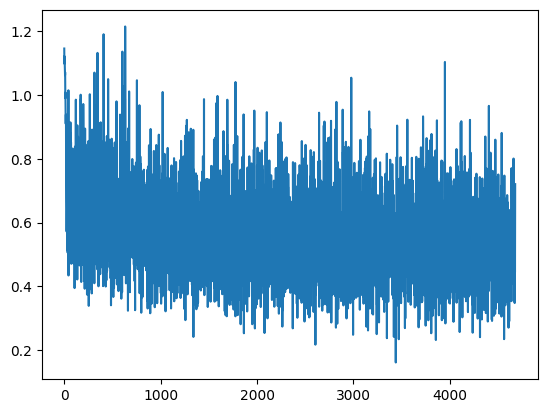

In [29]:
plt.plot(train_losses)

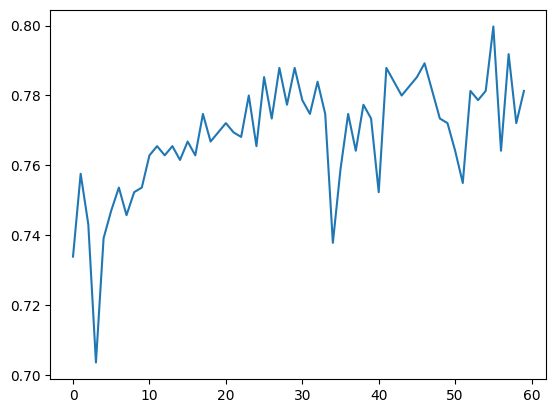

In [30]:
plt.plot(test_accuracy)

In [31]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 593/736 (0.8057)
{'acc_detail': tensor([0.8897, 0.7919, 0.7302], device='cuda:0'),
 'acc_unweighted': tensor(0.8039, device='cuda:0'),
 'acc_weighted': tensor(0.8057, device='cuda:0'),
 'f1s': tensor(0.8034, device='cuda:0'),
 'f1s_detail': tensor([0.8948, 0.7187, 0.7965], device='cuda:0'),
 'precision_detail': tensor([0.9000, 0.6579, 0.8762], device='cuda:0'),
 'recall_detail': tensor([0.8897, 0.7919, 0.7302], device='cuda:0'),
 'rocauc': tensor([0.9769, 0.9041, 0.9440], device='cuda:0'),
 'uar': tensor(0.8039, device='cuda:0'),
 'wap': tensor(0.8192, device='cuda:0')}


tensor([[234,  28,   1],
        [ 21, 175,  25],
        [  5,  63, 184]], device='cuda:0')

In [32]:
best_epoch = 56
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 607/736 (0.8247)
{'acc_detail': tensor([0.9049, 0.7330, 0.8214], device='cuda:0'),
 'acc_unweighted': tensor(0.8198, device='cuda:0'),
 'acc_weighted': tensor(0.8247, device='cuda:0'),
 'f1s': tensor(0.8197, device='cuda:0'),
 'f1s_detail': tensor([0.8964, 0.7281, 0.8347], device='cuda:0'),
 'precision_detail': tensor([0.8881, 0.7232, 0.8484], device='cuda:0'),
 'recall_detail': tensor([0.9049, 0.7330, 0.8214], device='cuda:0'),
 'rocauc': tensor([0.9771, 0.9029, 0.9421], device='cuda:0'),
 'uar': tensor(0.8198, device='cuda:0'),
 'wap': tensor(0.8250, device='cuda:0')}


tensor([[238,  23,   2],
        [ 24, 162,  35],
        [  6,  39, 207]], device='cuda:0')

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 440
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                           | 0.009900990099009901/440 [00:00<3:10:41, 26.00s/it]

Train Epoch: 61 [0/2508 (0%)]	Loss: 0.434723
Mem before-during-after: 21754880 1942141440 22811136


  0%|▏                                                                                                                                                                           | 0.40594059405940613/440 [00:10<3:29:09, 28.55s/it]

Train Epoch: 61 [1280/2508 (51%)]	Loss: 0.582526
Mem before-during-after: 22811136 1941254144 22811136


  0%|▍                                                                                                                                                                            | 1.0000000000000007/440 [00:24<2:24:01, 19.68s/it]


Test Epoch: 61	Accuracy: 596/736 (79%)



  0%|▍                                                                                                                                                                            | 1.0198019801980205/440 [00:25<2:38:45, 21.70s/it]

Train Epoch: 62 [0/2508 (0%)]	Loss: 0.496696
Mem before-during-after: 22807040 1943193600 22811136


  0%|▌                                                                                                                                                                             | 1.405940594059407/440 [00:35<3:20:36, 27.44s/it]

Train Epoch: 62 [1280/2508 (51%)]	Loss: 0.536091
Mem before-during-after: 22811136 1942032384 22811136


  0%|▊                                                                                                                                                                            | 2.0000000000000013/440 [00:49<2:31:17, 20.73s/it]


Test Epoch: 62	Accuracy: 606/736 (80%)



  0%|▊                                                                                                                                                                             | 2.019801980198021/440 [00:50<2:37:58, 21.64s/it]

Train Epoch: 63 [0/2508 (0%)]	Loss: 0.425441
Mem before-during-after: 22807040 1943193600 22811136


  1%|▉                                                                                                                                                                            | 2.4059405940594076/440 [01:00<3:25:36, 28.19s/it]

Train Epoch: 63 [1280/2508 (51%)]	Loss: 0.674731
Mem before-during-after: 22811136 1942032384 22811136


  1%|█▏                                                                                                                                                                            | 3.000000000000002/440 [01:15<2:36:21, 21.47s/it]


Test Epoch: 63	Accuracy: 584/736 (77%)



  1%|█▏                                                                                                                                                                            | 3.019801980198022/440 [01:15<2:37:28, 21.62s/it]

Train Epoch: 64 [0/2508 (0%)]	Loss: 0.442073
Mem before-during-after: 22807040 1943193600 22811136


  1%|█▎                                                                                                                                                                           | 3.4059405940594085/440 [01:25<3:26:28, 28.38s/it]

Train Epoch: 64 [1280/2508 (51%)]	Loss: 0.458862
Mem before-during-after: 22811136 1942032384 22811136


  1%|█▌                                                                                                                                                                            | 4.000000000000003/440 [01:40<2:25:39, 20.05s/it]


Test Epoch: 64	Accuracy: 568/736 (75%)



  1%|█▌                                                                                                                                                                            | 4.009900990099013/440 [01:40<2:38:07, 21.76s/it]

Train Epoch: 65 [0/2508 (0%)]	Loss: 0.390502
Mem before-during-after: 22807040 1943193600 22811136


  1%|█▋                                                                                                                                                                            | 4.405940594059409/440 [01:50<3:19:39, 27.50s/it]

Train Epoch: 65 [1280/2508 (51%)]	Loss: 0.511165
Mem before-during-after: 22811136 1942032384 22811136


  1%|█▉                                                                                                                                                                           | 5.0000000000000036/440 [02:05<2:24:15, 19.90s/it]


Test Epoch: 65	Accuracy: 591/736 (78%)



  1%|█▉                                                                                                                                                                            | 5.019801980198023/440 [02:05<2:36:38, 21.61s/it]

Train Epoch: 66 [0/2508 (0%)]	Loss: 0.569011
Mem before-during-after: 22807040 1943193600 22811136


  1%|██▏                                                                                                                                                                            | 5.40594059405941/440 [02:16<3:24:49, 28.28s/it]

Train Epoch: 66 [1280/2508 (51%)]	Loss: 0.402471
Mem before-during-after: 22811136 1942032384 22811136


  1%|██▎                                                                                                                                                                           | 6.000000000000004/440 [02:30<2:24:46, 20.02s/it]


Test Epoch: 66	Accuracy: 587/736 (77%)



  1%|██▍                                                                                                                                                                           | 6.019801980198024/440 [02:30<2:36:50, 21.68s/it]

Train Epoch: 67 [0/2508 (0%)]	Loss: 0.703362
Mem before-during-after: 22807040 1943193600 22811136


  1%|██▌                                                                                                                                                                           | 6.405940594059411/440 [02:40<3:25:20, 28.41s/it]

Train Epoch: 67 [1280/2508 (51%)]	Loss: 0.587296
Mem before-during-after: 22811136 1942032384 22811136


  2%|██▋                                                                                                                                                                           | 6.881188118811886/440 [02:52<2:23:25, 19.87s/it]

In [ ]:
np.save('../models_cremad3/cremad3_m12new_500epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_cremad3/cremad3_m12new_500epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

In [ ]:
best_epoch = 
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [125]:
# del model
# gc.collect()

895